In [1]:
import os, time, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import timm
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

OBJECTS = [
    "bottle","cable","capsule","carpet","grid",
    "hazelnut","leather","metal_nut","pill","screw",
    "tile","toothbrush","transistor","wood","zipper"
]
NUM_CLASSES = len(OBJECTS)

Mounted at /content/drive


In [5]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.samples = []
        self.transform = transform
        for obj_id, obj in enumerate(OBJECTS):
            base = Path(root) / obj / split
            if not base.exists(): continue
            for defect_dir in base.iterdir():
                if defect_dir.is_dir():
                    for img_path in defect_dir.glob("*.png"):
                        self.samples.append((img_path, obj_id))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

In [6]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_train_ds = MVTecObjectDataset(MVTEC_ROOT, "train", train_tfms)
train_size = int(0.9 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(SEED))

test_ds = MVTecObjectDataset(MVTEC_ROOT, "test", val_tfms)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

print(f"Data Loaded: {len(train_ds)} Train | {len(val_ds)} Val | {len(test_ds)} Test")

Data Loaded: 3267 Train | 363 Val | 1725 Test


In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
text_encoder.eval()
for p in text_encoder.parameters(): p.requires_grad = False

prompts = [f"a photo of a {o}" for o in OBJECTS]
tokens = tokenizer(prompts, padding=True, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    txt_feat = text_encoder(**tokens).pooler_output
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
lora_cfg = LoraConfig(r=16, lora_alpha=32, target_modules=["qkv"], lora_dropout=0.05)
vit = get_peft_model(vit, lora_cfg).to(DEVICE)

img_proj = nn.Linear(vit.model.num_features, txt_feat.shape[1]).to(DEVICE)
temp_init = torch.ones([]) * np.log(1 / 0.07)
logit_scale = nn.Parameter(temp_init.to(DEVICE))

optimizer = torch.optim.AdamW(
    list(vit.parameters()) + list(img_proj.parameters()) + [logit_scale],
    lr=1e-4, weight_decay=0.01
)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [8]:
EPOCHS = 3
start_train_time = time.time()
for epoch in range(EPOCHS):
    vit.train(); img_proj.train()
    train_loss = 0
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        features = vit(imgs)
        projected_feat = img_proj(features)
        projected_feat = projected_feat / projected_feat.norm(dim=1, keepdim=True)

        logits = (projected_feat @ txt_feat.t()) * logit_scale.exp()
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    vit.eval(); img_proj.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            feat = vit(imgs)
            feat = img_proj(feat)
            feat = feat / feat.norm(dim=1, keepdim=True)
            preds = (feat @ txt_feat.t()).argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    acc_val = val_correct / val_total
    print(f">> Epoch {epoch+1} Summary: Train Loss: {train_loss/len(train_dl):.4f} | Val Acc: {100*acc_val:.2f}%")
total_train_time = time.time() - start_train_time

Epoch 1/3 [Train]: 100%|██████████| 103/103 [21:58<00:00, 12.80s/it, loss=1.6328]


>> Epoch 1 Summary: Train Loss: 1.9678 | Val Acc: 85.12%


Epoch 2/3 [Train]: 100%|██████████| 103/103 [02:12<00:00,  1.29s/it, loss=0.9823]


>> Epoch 2 Summary: Train Loss: 1.4362 | Val Acc: 94.21%


Epoch 3/3 [Train]: 100%|██████████| 103/103 [02:11<00:00,  1.28s/it, loss=1.3730]


>> Epoch 3 Summary: Train Loss: 1.3273 | Val Acc: 96.69%


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

vit.eval()
img_proj.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_dl):
        imgs = imgs.to(DEVICE)

        feat = vit(imgs)
        feat = img_proj(feat)
        feat = feat / feat.norm(dim=1, keepdim=True)

        logits = feat @ txt_feat.t()
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

100%|██████████| 54/54 [12:07<00:00, 13.47s/it]


In [14]:
report = classification_report(all_labels, all_preds, target_names=OBJECTS, digits=4)
print(report)

              precision    recall  f1-score   support

      bottle     1.0000    1.0000    1.0000        83
       cable     1.0000    0.9933    0.9967       150
     capsule     1.0000    0.9848    0.9924       132
      carpet     1.0000    0.9829    0.9914       117
        grid     1.0000    1.0000    1.0000        78
    hazelnut     1.0000    1.0000    1.0000       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     0.9914    1.0000    0.9957       115
        pill     1.0000    0.3293    0.4955       167
       screw     1.0000    1.0000    1.0000       160
        tile     1.0000    0.9573    0.9782       117
  toothbrush     0.2658    1.0000    0.4200        42
  transistor     0.9524    1.0000    0.9756       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9293      1725
   macro avg     0.9473    0.9498    0.9230      1725
weighted avg     0.9788   

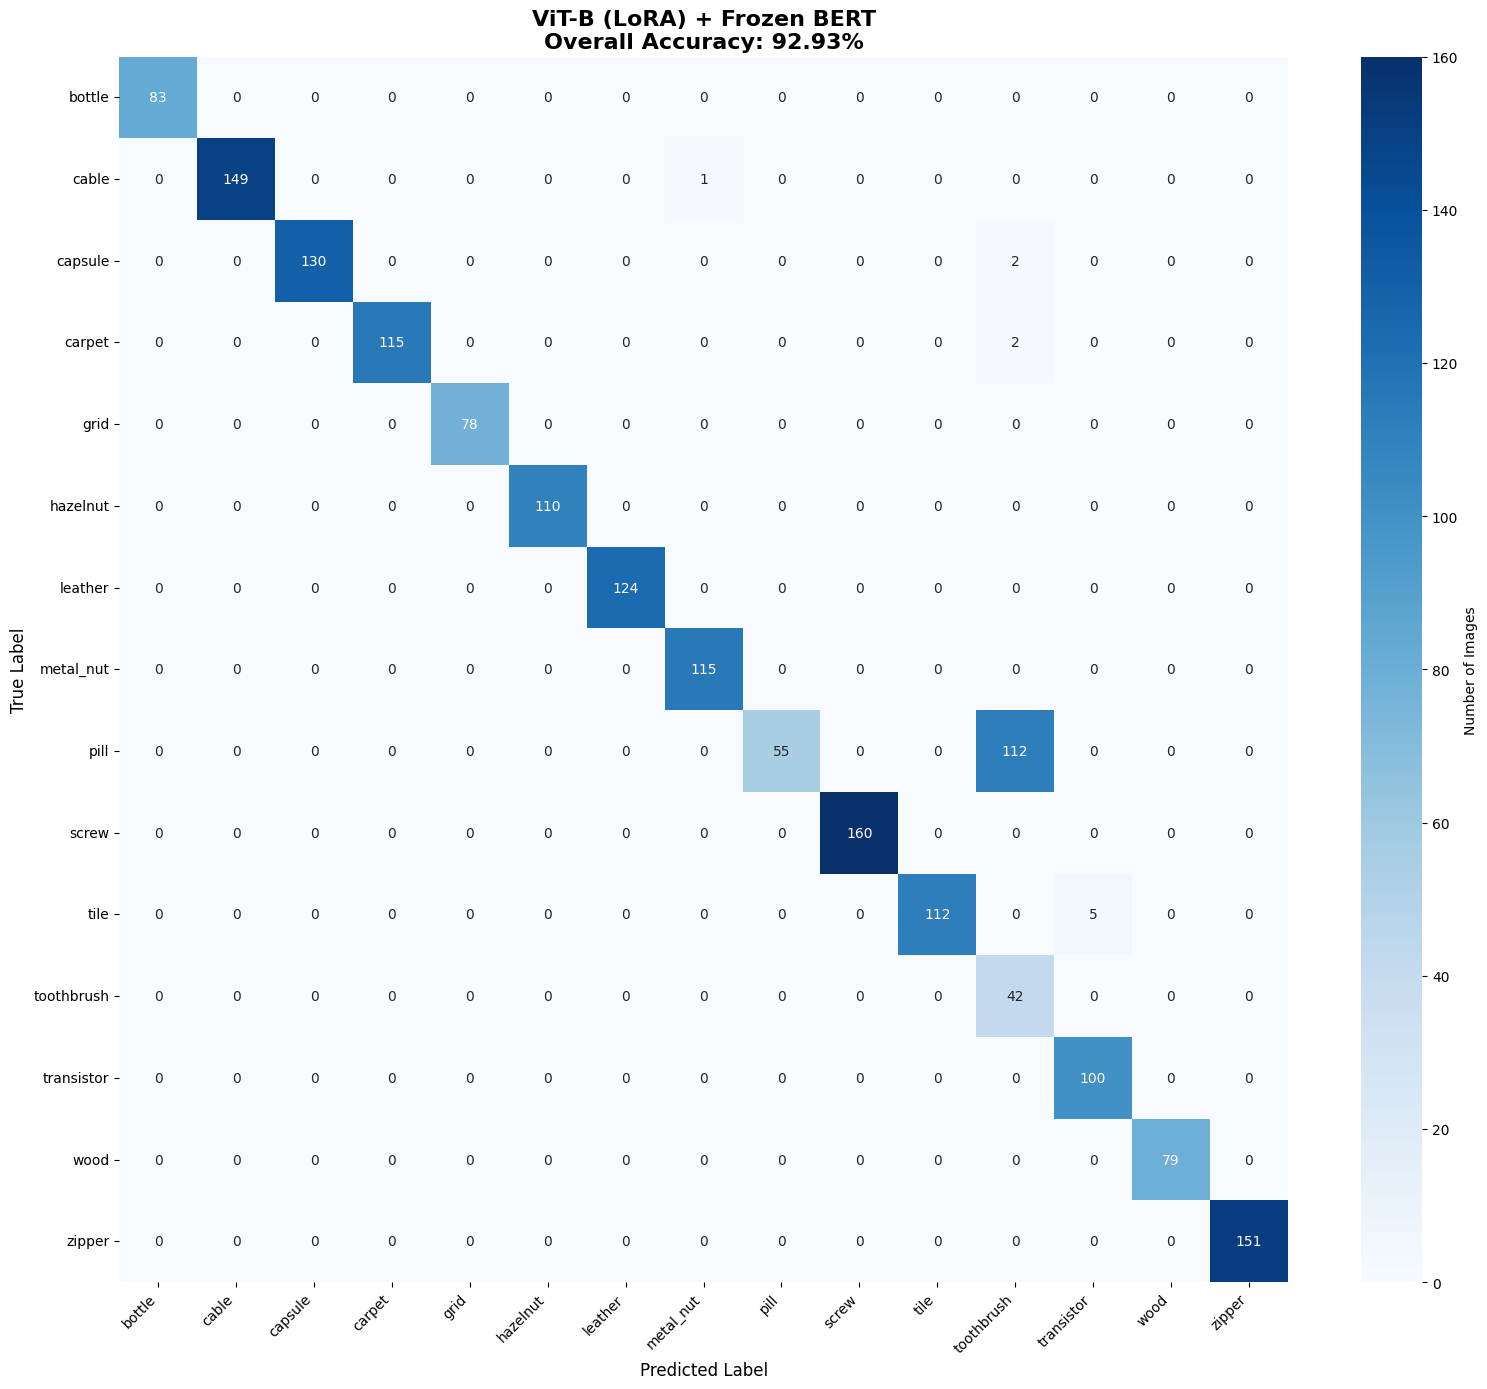

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Blues",
    cbar_kws={'label': 'Number of Images'}
)

plt.title(f"ViT-B (LoRA) + Frozen BERT\nOverall Accuracy: {acc*100:.2f}%", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
import random

class_examples = {}

for obj in OBJECTS:
    test_path = MVTEC_ROOT / obj / "test"
    all_imgs = list(test_path.glob("**/*.png"))

    if all_imgs:
        class_examples[obj] = str(random.choice(all_imgs))

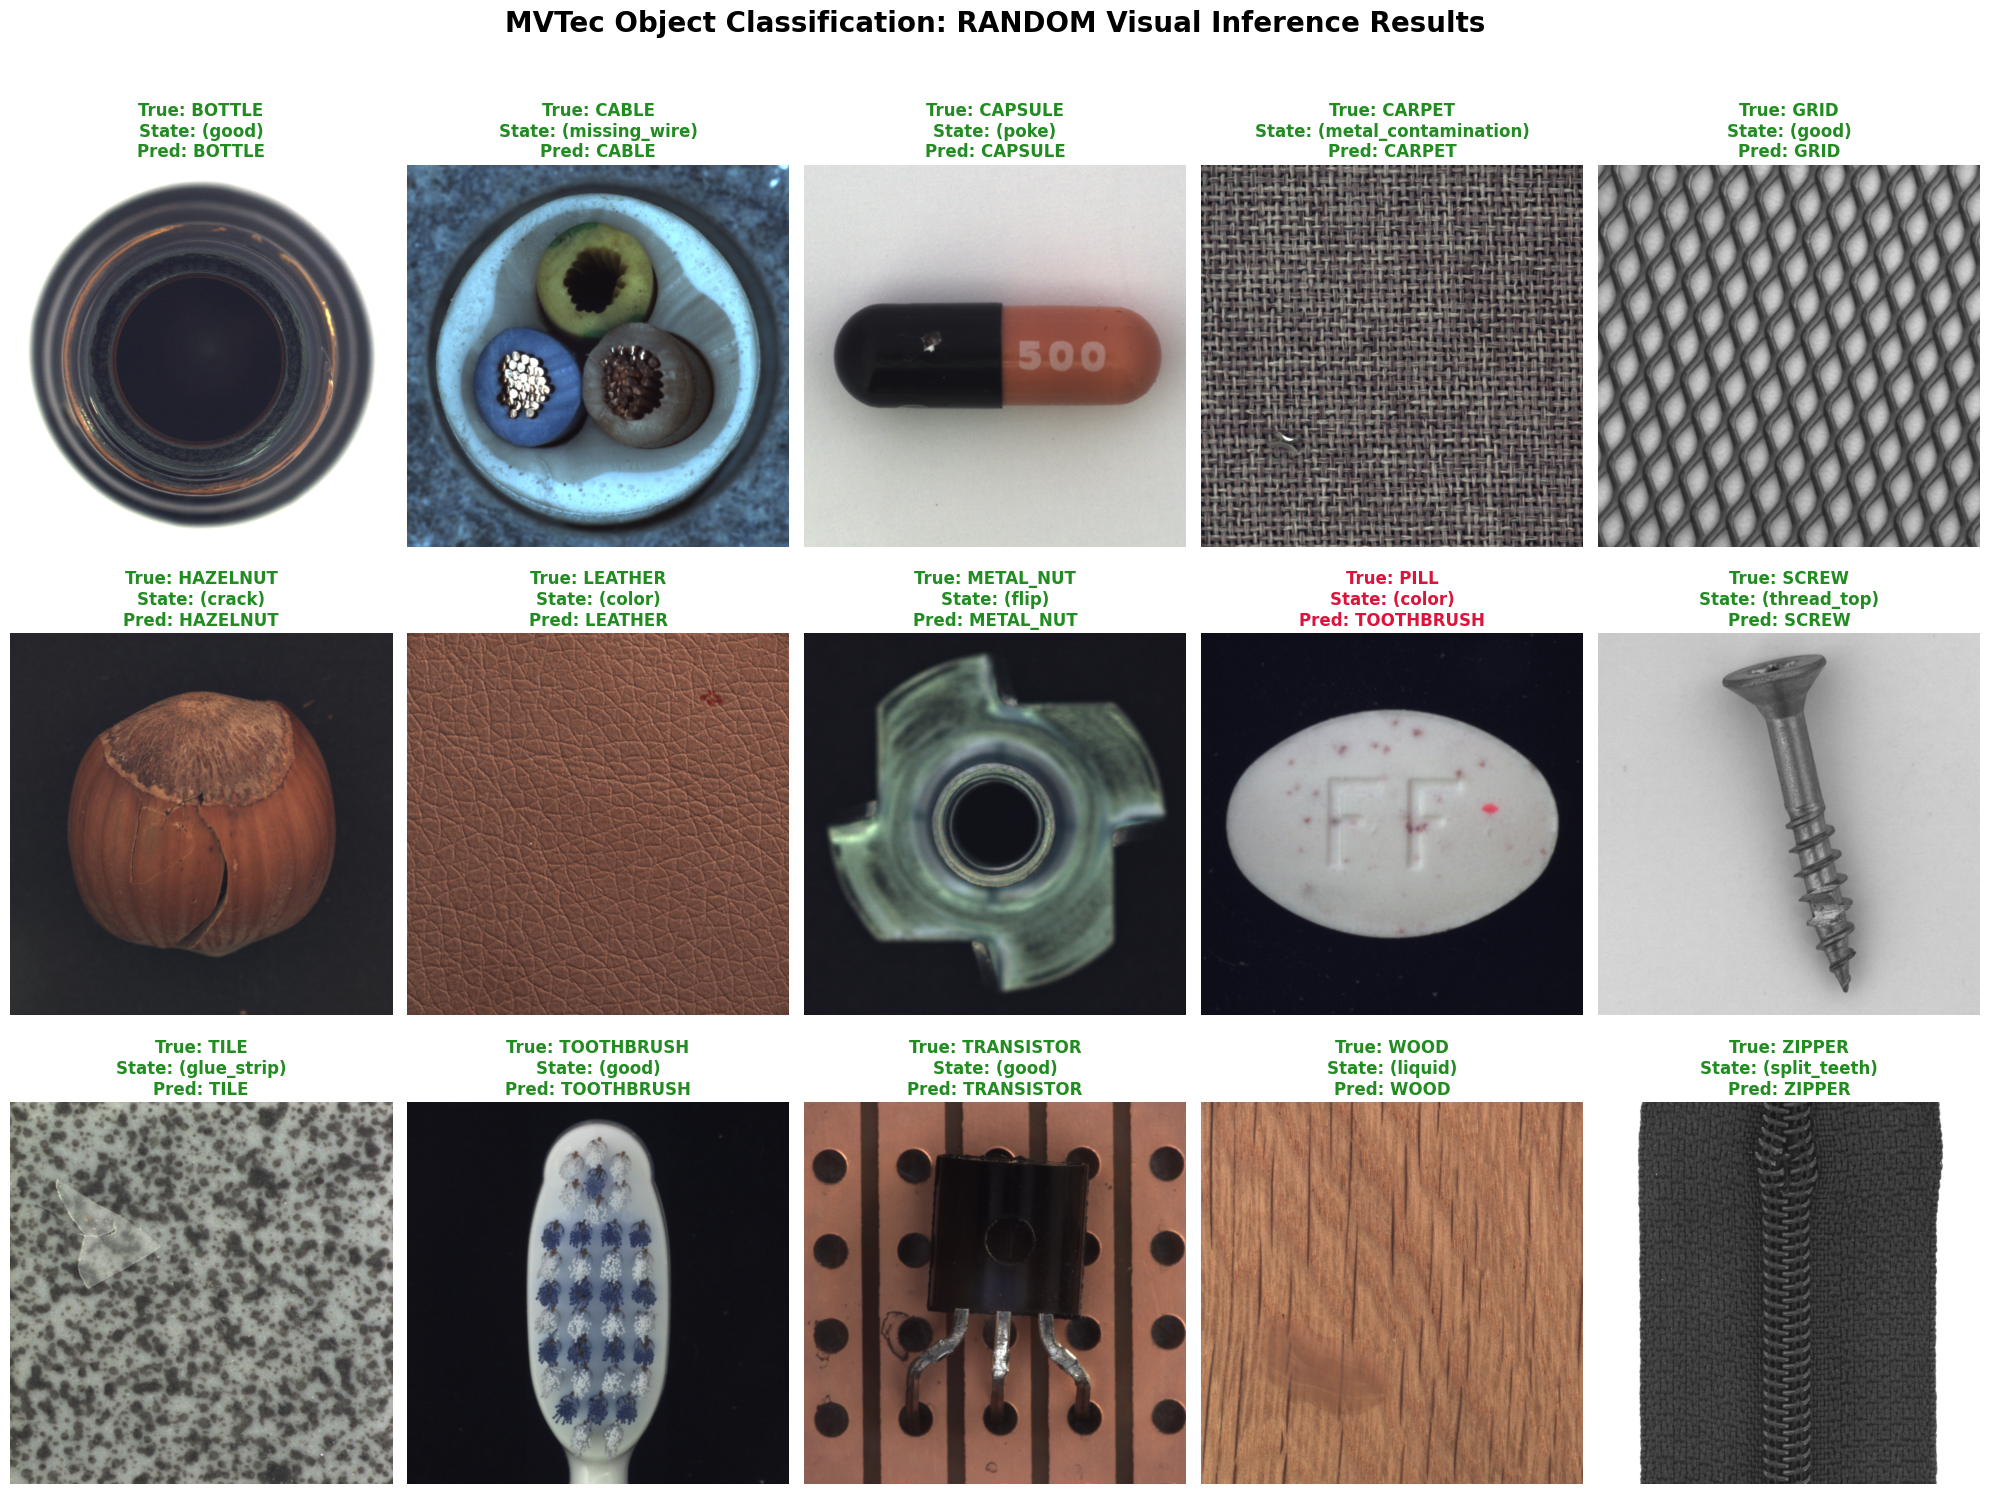

In [17]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random

vit.eval()
img_proj.eval()

class_examples = {}
for obj in OBJECTS:
    test_path = MVTEC_ROOT / obj / "test"
    all_imgs = list(test_path.glob("**/*.png"))
    if all_imgs:
        class_examples[obj] = str(random.choice(all_imgs))

plt.figure(figsize=(20, 15))
sorted_keys = sorted(class_examples.keys())


with torch.no_grad():
    for i, class_name in enumerate(sorted_keys):
        img_path = class_examples[class_name]
        img = Image.open(img_path).convert("RGB")

        defect_label = Path(img_path).parent.name

        img_t = val_tfms(img).unsqueeze(0).to(DEVICE)
        img_feat = vit(img_t)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T
        pred_idx = sims.argmax(1).item()
        pred_name = OBJECTS[pred_idx]

        is_correct = class_name.lower() == pred_name.lower()
        color = "forestgreen" if is_correct else "crimson"

        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(
            f"True: {class_name.upper()}\n"
            f"State: ({defect_label})\n"
            f"Pred: {pred_name.upper()}",
            color=color,
            fontsize=12,
            fontweight="bold"
        )
        plt.axis("off")

plt.suptitle("MVTec Object Classification: RANDOM Visual Inference Results",
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
!pip install fvcore
import torch.nn as nn
import time
from fvcore.nn import FlopCountAnalysis, flop_count_table

class InferenceModule(nn.Module):
    def __init__(self, vit_model, proj_layer):
        super().__init__()
        self.vit = vit_model
        self.proj = proj_layer

    def forward(self, x):
        with torch.no_grad():
            features = self.vit(x)
            return self.proj(features)

model_to_profile = InferenceModule(vit, img_proj).eval().to(DEVICE)
dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

flops = FlopCountAnalysis(model_to_profile, dummy_input)
flops.unsupported_ops_warnings(False)

total_flops = flops.total()
gflops = total_flops / 1e9
gmacs = (total_flops / 2) / 1e9

for _ in range(10):
    _ = model_to_profile(dummy_input)

start_time = time.time()
iterations = 100
for _ in range(iterations):
    _ = model_to_profile(dummy_input)
latency = ((time.time() - start_time) / iterations) * 1000
efficiency = (acc_val * 100) / gflops

# --- RESULTS ---
print("="*45)
print(f"{'INFERENCE METRIC':<25} | {'VALUE':<15}")
print("-" * 45)
print(f"{'Total GFLOPs':<25} | {gflops:.4f}")
print(f"{'Total GMACs':<25} | {gmacs:.4f}")
print(f"{'Latency (GPU)':<25} | {latency:.2f} ms")
print(f"{'Throughput (FPS)':<25} | {1000/latency:.2f} images/s")
print(f"{'Acc per GFLOP':<25} | {efficiency:.4f}")
print("-" * 45)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=8e5253bc0af64e886560b46308bba4c9d4e74c41ececa1e749dda09d1c3d3ce3
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=f982fd9a1a932bd8842576706476a50e1057509ea9849feeb23c37acdd97beb1
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


vit.base_model.model.blocks.0.attn.attn_drop, vit.base_model.model.blocks.1.attn.attn_drop, vit.base_model.model.blocks.10.attn.attn_drop, vit.base_model.model.blocks.11.attn.attn_drop, vit.base_model.model.blocks.2.attn.attn_drop, vit.base_model.model.blocks.3.attn.attn_drop, vit.base_model.model.blocks.4.attn.attn_drop, vit.base_model.model.blocks.5.attn.attn_drop, vit.base_model.model.blocks.6.attn.attn_drop, vit.base_model.model.blocks.7.attn.attn_drop, vit.base_model.model.blocks.8.attn.attn_drop, vit.base_model.model.blocks.9.attn.attn_drop


INFERENCE METRIC          | VALUE          
---------------------------------------------
Total GFLOPs              | 4.3087
Total GMACs               | 2.1543
Latency (GPU)             | 7.94 ms
Throughput (FPS)          | 126.00 images/s
Acc per GFLOP             | 22.4417
---------------------------------------------


In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

vit_trainable = count_parameters(vit)
proj_trainable = count_parameters(img_proj)
total_trainable = vit_trainable + proj_trainable

total_params = sum(p.numel() for p in vit.parameters()) + sum(p.numel() for p in img_proj.parameters())

print("-" * 45)
print(f"{'Metric':<25} | {'Value':<15}")
print("-" * 45)
print(f"{'EMBED_DIM':<25} | 384")
print(f"{'BATCH_SIZE':<25} | 32")
print(f"{'EPOCHS':<25} | {EPOCHS}")
print(f"{'LR':<25} | 1e-4")
print(f"{'Optimizer':<25} | AdamW")
print(f"{'Image Encoder':<25} | ViT-Small (22M)")
print(f"{'Text Encoder':<25} | BERT-Base (110M)")
print(f"{'LoRA Rank (r)':<25} | {lora_cfg.r}")
print(f"{'LoRA Alpha':<25} | {lora_cfg.lora_alpha}")
print("-" * 45)
print(f"{'Trainable Backbone':<25} | {vit_trainable/1e6:.2f}M")
print(f"{'Trainable Proj':<25} | {proj_trainable/1e6:.2f}M")
print(f"{'Total Trainable':<25} | {total_trainable/1e6:.2f}M")
print(f"{'Trainable %':<25} | {(total_trainable / total_params * 100):.2f}%")
print("-" * 45)

---------------------------------------------
Metric                    | Value          
---------------------------------------------
EMBED_DIM                 | 384
BATCH_SIZE                | 32
EPOCHS                    | 3
LR                        | 1e-4
Optimizer                 | AdamW
Image Encoder             | ViT-Small (22M)
Text Encoder              | BERT-Base (110M)
LoRA Rank (r)             | 16
LoRA Alpha                | 32
---------------------------------------------
Trainable Backbone        | 0.29M
Trainable Proj            | 0.30M
Total Trainable           | 0.59M
Trainable %               | 2.65%
---------------------------------------------


In [20]:
import torch
from pathlib import Path

SAVE_DIR = Path("/content/drive/MyDrive/VitS")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

final_train_time = total_train_time if 'total_train_time' in locals() else 0

ckpt = {
    "vit_state": vit.state_dict(),
    "img_proj_state": img_proj.state_dict(),
    "txt_feat": txt_feat.cpu(),

    "objects": OBJECTS,
    "model_name": "vit_small_patch16_224",
    "lora_cfg": {
        "r": lora_cfg.r,
        "lora_alpha": lora_cfg.lora_alpha,
        "target_modules": lora_cfg.target_modules,
        "lora_dropout": lora_cfg.lora_dropout,
    },

    "train_time_min": final_train_time / 60,
    "epochs": EPOCHS,
    "seed": SEED,
}

save_path = SAVE_DIR / "vits_lora_mvtec.pt"
torch.save(ckpt, save_path)
print(f"Model saved successfully to: {save_path}")

Model saved successfully to: /content/drive/MyDrive/VitS/vits_lora_mvtec.pt


Load the model directly


In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import timm
from peft import LoraConfig, get_peft_model

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
SAVE_DIR = Path("/content/drive/MyDrive/VitS")
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")
CKPT_PATH = SAVE_DIR / "vits_lora_mvtec.pt"

In [27]:
print(f"Loading checkpoint from: {CKPT_PATH}")
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
OBJECTS = ckpt["objects"]
NUM_CLASSES = len(OBJECTS)
print(f"Number of object classes: {NUM_CLASSES}")
print(f"Model name in checkpoint: {ckpt['model_name']}")

Loading checkpoint from: /content/drive/MyDrive/VitS/vits_lora_mvtec.pt
Number of object classes: 15
Model name in checkpoint: vit_small_patch16_224


In [28]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="test", transform=None):
        self.samples = []
        self.transform = transform
        for obj_id, obj in enumerate(OBJECTS):
            base = Path(root) / obj / split
            if not base.exists():
                continue
            for defect_dir in base.iterdir():
                if defect_dir.is_dir():
                    for img_path in defect_dir.glob("*.png"):
                        self.samples.append((img_path, obj_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_ds = MVTecObjectDataset(MVTEC_ROOT, "test", val_tfms)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)
print(f"Number of test samples: {len(test_ds)}")

vit = timm.create_model(ckpt["model_name"], pretrained=False, num_classes=0)
lora_cfg = LoraConfig(**ckpt["lora_cfg"])
vit = get_peft_model(vit, lora_cfg).to(DEVICE)
vit.load_state_dict(ckpt["vit_state"])

img_proj = nn.Linear(vit.model.num_features, ckpt["txt_feat"].shape[1]).to(DEVICE)
img_proj.load_state_dict(ckpt["img_proj_state"])

txt_feat = ckpt["txt_feat"].to(DEVICE)

vit.eval()
img_proj.eval()

Number of test samples: 1725


Linear(in_features=384, out_features=768, bias=True)

In [29]:
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)

        features = vit(imgs)
        features = img_proj(features)
        features = features / features.norm(dim=1, keepdim=True)

        logits = features @ txt_feat.T
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


Test Accuracy: 92.93%

Classification Report:

              precision    recall  f1-score   support

      bottle     1.0000    1.0000    1.0000        83
       cable     1.0000    0.9933    0.9967       150
     capsule     1.0000    0.9848    0.9924       132
      carpet     1.0000    0.9829    0.9914       117
        grid     1.0000    1.0000    1.0000        78
    hazelnut     1.0000    1.0000    1.0000       110
     leather     1.0000    1.0000    1.0000       124
   metal_nut     0.9914    1.0000    0.9957       115
        pill     1.0000    0.3293    0.4955       167
       screw     1.0000    1.0000    1.0000       160
        tile     1.0000    0.9573    0.9782       117
  toothbrush     0.2658    1.0000    0.4200        42
  transistor     0.9524    1.0000    0.9756       100
        wood     1.0000    1.0000    1.0000        79
      zipper     1.0000    1.0000    1.0000       151

    accuracy                         0.9293      1725
   macro avg     0.9473    0.949

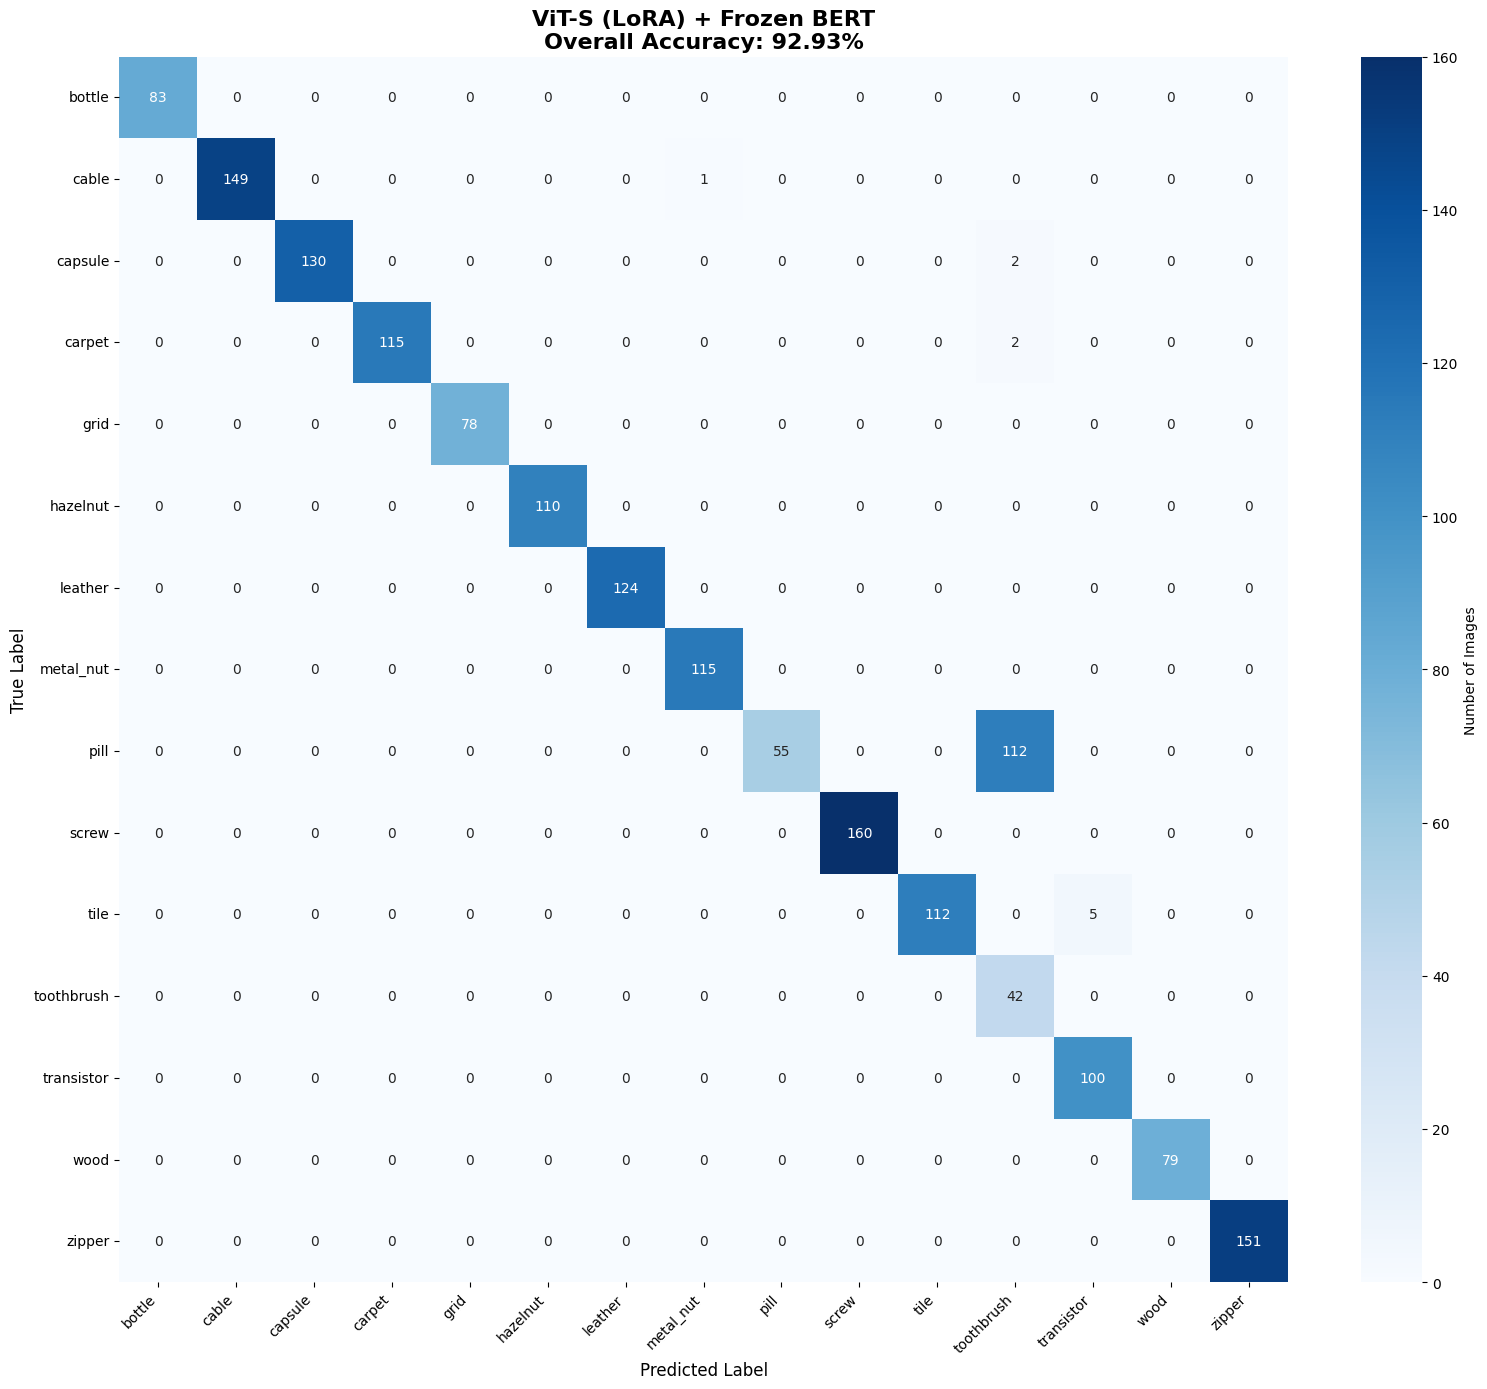

In [30]:
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc*100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=OBJECTS, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Blues",
    cbar_kws={'label': 'Number of Images'}
)
plt.title(f"ViT-S (LoRA) + Frozen BERT\nOverall Accuracy: {acc*100:.2f}%", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()